# Ford vs Ferrari - Alexey - DST-65

In [ ]:
# проверяем, что видеокарта подключена
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c71d5ed3-269a-2ecf-73ca-865656396c82)


In [ ]:
# подготавливаем данные

# для Google Colab:
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'
train_path = '/content/train/'
sub_path = '/content/test_upload/'

# для Kaggle Kernel
# !mkdir /kaggle/temp #папка для временных файлов
# !unzip /kaggle/input/train.zip -d /kaggle/temp
# !unzip /kaggle/input/test.zip -d /kaggle/temp
# sample_submission_path = '/kaggle/input/sample-submission.csv'
# train_path = '/kaggle/temp/train/'
# sub_path = '/kaggle/temp/test_upload/'
# %cd /kaggle/working  #переходим в рабочую директорию

#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
| [1 files][  1.6 GiB/  1.6 GiB]   40.2 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
   creating: sf-dl-car-classification/
  inflating: sf-dl-car-classification/sample-submission.csv  
  inflating: sf-dl-car-classification/train.csv  
 extracting: sf-dl-car-classification/test.zip  
 extracting: sf-dl-car-classification/train.zip  


In [ ]:
# импорты

import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

**Создаем генераторы изображений**

In [ ]:
image_size = (90, 120)
batch_size = 32

train_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
)

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


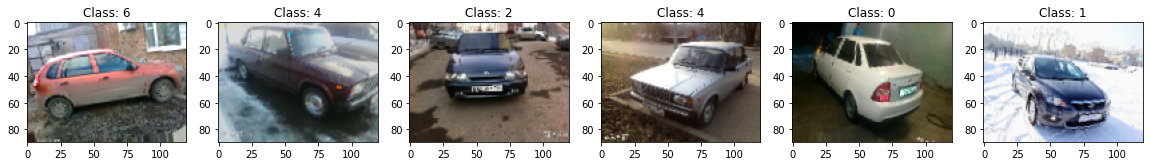

Val:


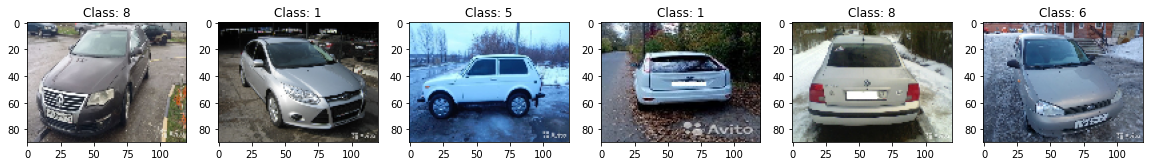

Sub:


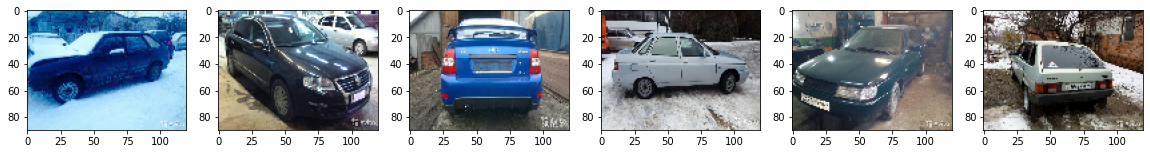

In [ ]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

In [ ]:
# строим модель
model = Sequential([
  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy'
)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# обучаем модель
model.fit(train_generator, validation_data=val_generator, epochs=1)

390/390 [==============================] - 174s 387ms/step - loss: 2.0532 - accuracy: 0.4149 - val_loss: 0.9432 - val_accuracy: 0.6565


**Baseline model summary:**

*   Точность на обучающих данных, усредненная по первой эпохе, равна **0.4149**
*   Точность на валидационных данных в конце первой эпохи равна **0.6565**

Сделаем файл для сабмита:

In [ ]:
predictions = model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)

209/209 [==============================] - 40s 185ms/step


# Что дальше?

Предлагаемый план действий:
1.    Разберите код бейзлайна
1.    Создайте копию ноутбука, удалите все лишнее и оставьте только код
1.    Ищите способы улучшить решение и повысить точность

Рекомендации о том, как повысить точность
*   Обучайте дольше и на большем разрешении
*   Пробуйте использовать другие модели и ансамбли
*   Сделайте больше аугментаций, но не чрезмерно (следите за точностью на валидации)
*   Управляйте learning rate
*   Измените соотношение размеров train/val датасетов
*   Используйте TTA (test-time augmentations)
*   Поищите в интернете обученные нейронные сети для работы с автомобилями
*   Скачайте из интернета дополнительные изображения для обучения
*   Смотрите ноутбуки с решениями других Kaggle-соревнований по CV


# 1. Baseline model

In [ ]:
# save base model
base_model = EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False)

In [ ]:
#declare constants
CLASS_NUM = 10
LR = 1e-3 # it was defined empirically that this values is the best for learning 
EPOCHS = 5 # epochs count that should be enough for learning

# 2. Fine-tuning model

In [ ]:
# Checking number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  237


In [ ]:
# Check number of trainable layers
len(base_model.trainable_variables)

107

In [ ]:
# building a model
model2 = Sequential([
  base_model, #pre-trained neural network from keras.applications module
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(CLASS_NUM)
])

model2.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(LR, 100, 0.9)),
    metrics='accuracy'
)

In [ ]:
# Training a model
model2.fit(train_generator, validation_data=val_generator, epochs=1)

390/390 [==============================] - 153s 360ms/step - loss: 1.2913 - accuracy: 0.5485 - val_loss: 0.8558 - val_accuracy: 0.6854


**Fine-Tuning (model2) summary:**

*   Точность на обучающих данных, усредненная по первой эпохе, равна **0.4019**
*   Точность на валидационных данных в конце первой эпохи равна **0.6041**

Точность уменьшилась, по сравнению с baseline model.

# 3. Оптимизация модели
В ходе экспериментов, использовались
 * подбор LR, optimizer, loss и других переменных
 * подобраны парамерты в ImageDataGenerator
 * увеличено количество эпох для обучения до 4.
 * добавлен callback
 * попробованы другие архитектуры сетей
 * добавлен слой Batch Normalization
 
В итоге лучше результаты были получены при следующих настройках:

In [ ]:
LR = 1e-4
EPOCHS = 4
INPUT_SHAPE = (60, 90, 3)
BATCH_SIZE = 32

train_datagen3 = ImageDataGenerator(
     featurewise_center=False,  # set input mean to 0 over the dataset
     samplewise_center=False,  # set each sample mean to 0
     featurewise_std_normalization=False,  # divide inputs by std of the dataset
     samplewise_std_normalization=False,  # divide each input by its std
     zca_whitening=False,  # apply ZCA whitening
     rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
     zoom_range = 0.2, # Randomly zoom image 
     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
     horizontal_flip = True,  # randomly flip images
     vertical_flip=False
)

train_generator3 = train_datagen3.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

# An object for storing the model learning metrics
history3 = History()

# Adding callback for saving the model with the best accuracy
checkpoint = ModelCheckpoint('model3.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks = [history3, checkpoint, earlystop]

Found 15561 images belonging to 10 classes.


In [ ]:
# building a model
#base_model = EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False)
base_model3 = EfficientNetB3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

model3 = Sequential([
  base_model3, #pre-trained neural network from keras.applications module
  GlobalAveragePooling2D(),
  BatchNormalization(),
  Dropout(0.25),
  Dense(256,activation='relu'),
  BatchNormalization(),
  Dense(CLASS_NUM, activation='softmax')
])

model3.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(LR, 100, 0.9)),
    metrics='accuracy')

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
#Training a model
model3.fit(train_generator3, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks) 

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


487/487 [==============================] - ETA: 0s - loss: 2.4808 - accuracy: 0.2012
Epoch 1: saving model to model3.hdf5
487/487 [==============================] - 212s 392ms/step - loss: 2.4808 - accuracy: 0.2012 - val_loss: 1.8722 - val_accuracy: 0.3374
Epoch 2/4
487/487 [==============================] - ETA: 0s - loss: 1.9597 - accuracy: 0.3260
Epoch 2: saving model to model3.hdf5
487/487 [==============================] - 184s 377ms/step - loss: 1.9597 - accuracy: 0.3260 - val_loss: 1.5681 - val_accuracy: 0.4268
Epoch 3/4
487/487 [==============================] - ETA: 0s - loss: 1.7343 - accuracy: 0.3932
Epoch 3: saving model to model3.hdf5
487/487 [==============================] - 184s 377ms/step - loss: 1.7343 - accuracy: 0.3932 - val_loss: 1.4099 - val_accuracy: 0.4892
Epoch 4/4
487/487 [==============================] - ETA: 0s - loss: 1.5883 - accuracy: 0.4380
Epoch 4: saving model to model3.hdf5
487/487 [==============================] - 183s 376ms/step - loss: 1.5883 - a

In [ ]:
# Let`s show the learning metrics for the model on the chart
def plotResults(data) :
  acc = data.history['accuracy']
  val_acc = data.history['val_accuracy']
  loss = data.history['loss']
  val_loss = data.history['val_loss']
 
  epochs = range(len(acc))
 
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
 
  plt.figure()
 
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
 
  plt.show()

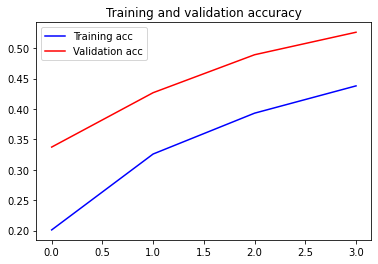

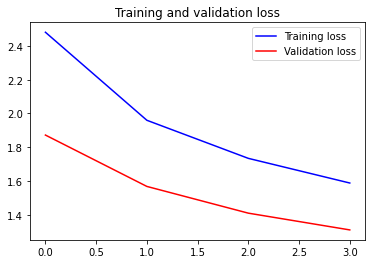

In [ ]:
plotResults(history3)

**Model 3 summary:**

*   Точность на обучающих данных, усредненная по 4 эпохам, равна **0.4380**
*   Точность на валидационных данных в конце 4 эпохи равна **0.5262**


# 4. Продвинутый уровень
 * аугментации, TTA (Test Time Augmentation)
 * техники управления Learning Rate
 
В итоге лучше результаты были получены при следующих настройках:

In [ ]:
!pip install albumentations -q -U

In [ ]:
# pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [ ]:
# pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.9 MB/s 


Found 15561 images belonging to 10 classes.


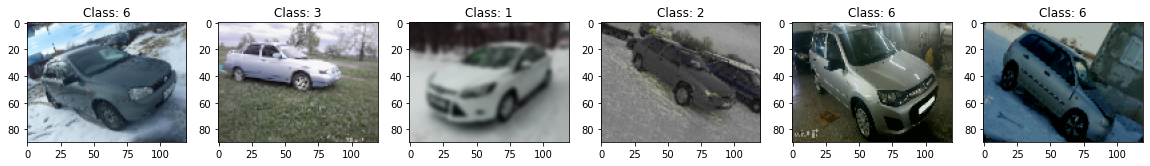

Found 15561 images belonging to 10 classes.


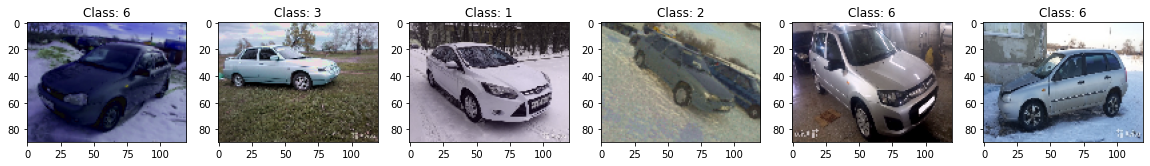

Found 15561 images belonging to 10 classes.


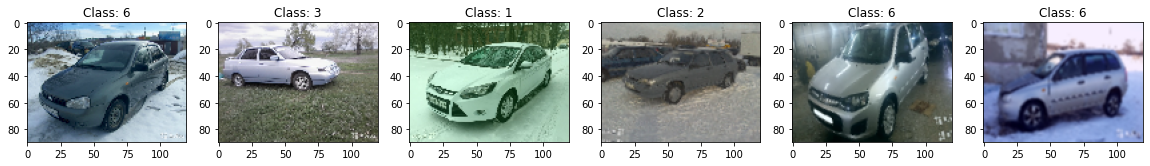

In [ ]:
import albumentations as A

def augment(image):
  image = image.astype(np.uint8)
  aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
        A.OneOf([
            A.CenterCrop(height=90, width=120),
            A.CenterCrop(height=90, width=120),
        ],p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
        ],p=0.5),
        A.GaussianBlur(p=0.05),
        A.HueSaturationValue(p=0.5),
        A.RGBShift(p=0.5),
        A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
        A.Resize(90, 120)
  ])
  return aug(image=image)['image']

train_datagen4 = ImageDataGenerator(
    preprocessing_function=augment
)

for _ in range(3):
  train_generator4 = train_datagen4.flow_from_directory(
      train_path,
      target_size=(90, 120),
      batch_size=32,
      shuffle=True,
      seed=0
  )
  show_first_images(train_generator4)

In [ ]:
LR = 1e-3
EPOCHS = 5
INPUT_SHAPE = (90, 120, 3)
BATCH_SIZE = 32

# An object for storing the model learning metrics
history4 = History()

# Adding callback for saving the model with the best accuracy
checkpoint = ModelCheckpoint('model4.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks = [history4, checkpoint, earlystop]

Found 6675 validated image filenames.


In [ ]:
# building a model
base_model4 = EfficientNetB3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

model4 = Sequential([
  base_model4, #pre-trained neural network from keras.applications module
  GlobalAveragePooling2D(),
  BatchNormalization(),
  Dropout(0.25),
  Dense(256,activation='relu'),
  BatchNormalization(),
  Dense(CLASS_NUM, activation='softmax')
])

model4.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(LR, 100, 0.9)),
    metrics='accuracy')

In [ ]:
  train_generator4 = train_datagen4.flow_from_directory(
      train_path,
      target_size=(90, 120),
      batch_size=32,
      shuffle=True,
      seed=0
  )

Found 15561 images belonging to 10 classes.


In [ ]:
#Training a model
model4.fit(train_generator4, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks) 

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


487/487 [==============================] - ETA: 0s - loss: 1.6247 - accuracy: 0.4404
Epoch 1: saving model to model4.hdf5
487/487 [==============================] - 232s 426ms/step - loss: 1.6247 - accuracy: 0.4404 - val_loss: 0.7339 - val_accuracy: 0.7231
Epoch 2/5
487/487 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.7183
Epoch 2: saving model to model4.hdf5
487/487 [==============================] - 189s 389ms/step - loss: 0.7961 - accuracy: 0.7183 - val_loss: 0.4155 - val_accuracy: 0.8501
Epoch 3/5
487/487 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.8043
Epoch 3: saving model to model4.hdf5
487/487 [==============================] - 191s 391ms/step - loss: 0.5532 - accuracy: 0.8043 - val_loss: 0.2507 - val_accuracy: 0.9138
Epoch 4/5
487/487 [==============================] - ETA: 0s - loss: 0.4197 - accuracy: 0.8507
Epoch 4: saving model to model4.hdf5
487/487 [==============================] - 194s 398ms/step - loss: 0.4197 - a

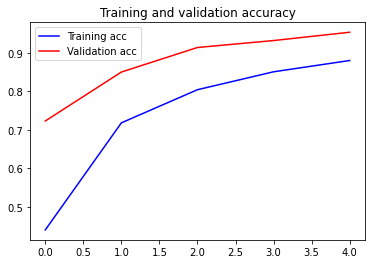

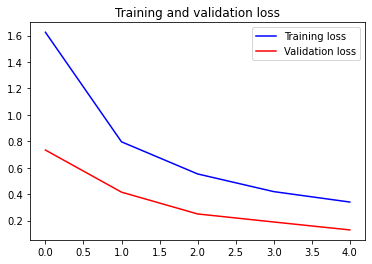

In [ ]:
plotResults(history4)

Model 4 summary:

Точность на обучающих данных, усредненная по 5 эпохам, равна **0.88**  
Точность на валидационных данных в конце 5 эпохи равна **0.9534**

Хороший результат, на нем и остановимся

### Test-time augmentations (TTA)

Found 6675 validated image filenames.


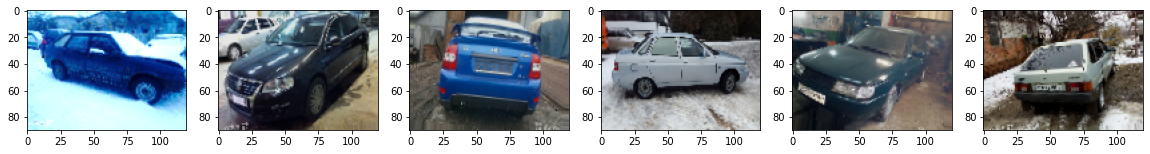

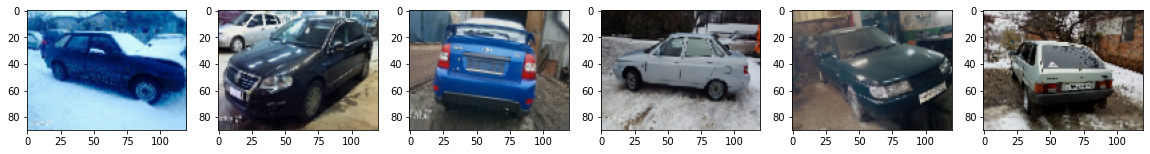

In [ ]:
sub_datagen = ImageDataGenerator(
    #rescale=1/255
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2)
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=(90, 120),
    batch_size=32,
    shuffle=False
)

show_first_images(sub_generator, labels=False)
sub_generator.reset()
show_first_images(sub_generator, labels=False)

Сделаем предсказания 5 раз:

In [ ]:
predictions = []
for _ in range(5):
  predictions.append(model.predict(sub_generator, verbose=1))
  sub_generator.reset()
predictions = np.array(predictions)
predictions.shape

209/209 [==============================] - 62s 298ms/step


(5, 6675, 10)

Делаем усреднение по номеру попытки, а затем argmax по номеру класса (не наоборот!):

In [ ]:
final_predictions = predictions.mean(axis=0).argmax(axis=-1)
final_predictions

array([9, 0, 4, ..., 1, 3, 4])

Смотрим насколько совпали предсказания на каждом изображении с разными аугментациями (цвет на изображении означает класс):

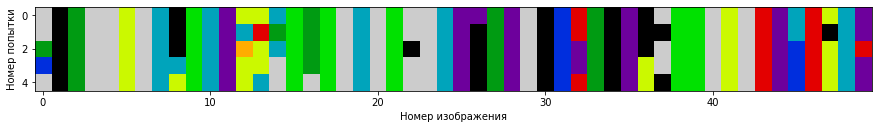

In [ ]:
plt.figure(figsize=(15, 3))
plt.imshow(predictions.argmax(axis=-1)[:, :50], cmap='nipy_spectral')
plt.xlabel('Номер изображения')
plt.ylabel('Номер попытки')
plt.show()

Делаем аугментации с помощью слоев keras, то можно получить генератор изображений для сабмита таким образом:

Found 6675 validated image filenames.


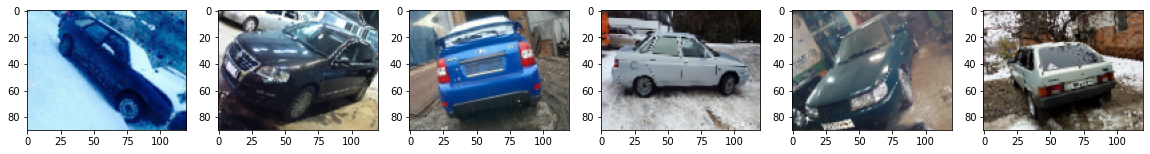

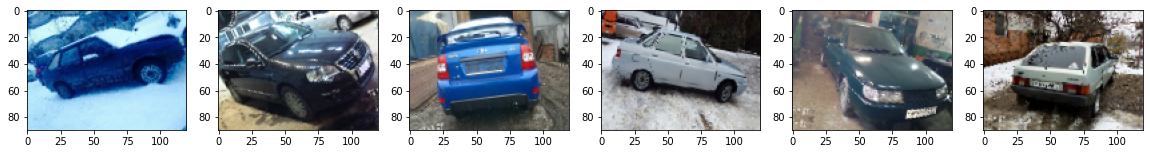

In [ ]:
preprocessing_model = Sequential([
  RandomCrop(90, 120),
  RandomFlip(mode='horizontal'),
  RandomRotation(0.1)
])

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=(90, 120),
    batch_size=32,
    shuffle=False
)

sub_generator_augmented = (preprocessing_model(x, training=True).numpy() for x in sub_generator)

show_first_images(sub_generator_augmented, labels=False)
sub_generator.reset()
show_first_images(sub_generator_augmented, labels=False)

In [ ]:
# Sumbitting predictions
submission_final = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': final_predictions
}, columns=['Id', 'Category'])

submission_final.to_csv('submission_final.csv', index=False)

### Ансамблирование

Самый простой способ ансамблирования - усреднение предсказаний нескольких моделей.

In [ ]:
predictions = 0.15*model2.predict(sub_generator) \
    + 0.15*model3.predict(sub_generator) \
    + 0.7*model4.predict(sub_generator)
predictions = predictions.argmax(axis=1)
predictions

array([9, 6, 4, ..., 1, 3, 4])

In [ ]:
# Sumbitting predictions
submission_final = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])

submission_final.to_csv('submission_ans.csv', index=False)

### Получение предсказания модели на изображении

Получить предсказание модели для произвольного изображения можно таким образом:

In [98]:
def play(file_name):
  #какого размера изображение модель принимает на вход?
  img_size = np.array(model.input.shape)[[2, 1]]

  # загружаем изображение с помощью PIL
  from PIL import Image
  image = np.array(Image.open(file_name).convert('RGB').resize(img_size)) #.convert('RGB') нужен на случай, если изображение черно-белое

  plt.imshow(image)
  plt.show()

  # превращаем изображение в батч из одного изображения, добавляя новую ось в начале
  image = image[None, ...]

  # делаем нормализацию, если это нужно для нашей модели
  # image = image / 255

  # получаем батч предсказаний и берем нулевой элемент
  pred = model4.predict(image)[0]

  # берем индекс класса с максимальным значением
  class_idx = pred.argmax()

  # получаем название
  print(class_names[class_idx])

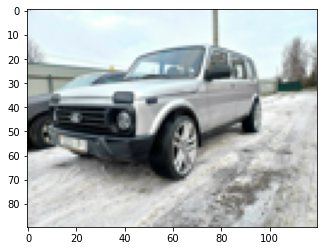

Нива


In [99]:
play('car_niva.jpeg')

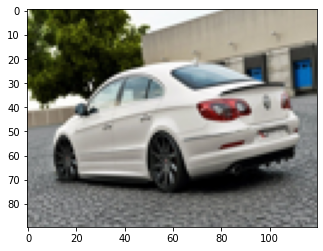

Volkswagen Passat


In [100]:
play('car_passat.jpg')

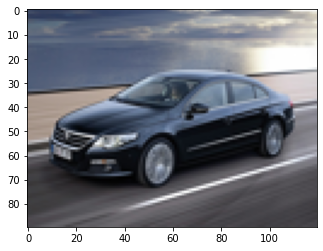

Ford Focus


In [101]:
play('car_passat2.jpg')

# Импортируем модель

In [104]:
with open('car_classification_model_alexey.pkl', 'wb') as output:
       pickle.dump(model4, output)

INFO:tensorflow:Assets written to: ram://0d643eb2-e442-4e35-aacd-bf1d34aae834/assets
